In [ ]:
import os
os.getcwd()

# Mount File System for Working on Colaboratory

# Running or importing .py Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory

In [ ]:
!ls

In [ ]:
!ls 'drive/My Drive/pytorch-EverybodyDanceNow/notebook'

In [1]:
import os
os.chdir('drive/My Drive/pytorch-EverybodyDanceNow/notebook')

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'drive/My Drive/pytorch-EverybodyDanceNow/notebook'

In [1]:
import os
import numpy as np
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.multiprocessing.set_sharing_strategy('file_system')
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(0)



import time
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd import Variable
from pathlib import Path

%matplotlib inline

In [2]:
pix2pixhd_dir = Path('../src/pix2pixHD/')

import sys
sys.path.append(str(pix2pixhd_dir))

print(str(pix2pixhd_dir))

..\src\pix2pixHD


In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

# Download and extract video

In [5]:
import cv2
from pathlib import Path

In [6]:
save_dir = Path('../data/source/')
print("Source data dir: ",save_dir)

try:
    save_dir.mkdir(True)

except FileExistsError:
    print("Directory exists")
    

img_dir = save_dir.joinpath('images')

print(img_dir)

try:
    img_dir.mkdir(True)
except FileExistsError:
    print("Directory exists")





Source data dir:  ..\data\source
Directory exists
..\data\source\images
Directory exists


# Get Frames from Video

In [7]:
print(str(save_dir.joinpath('file_name.mp4')))
cap = cv2.VideoCapture( str(save_dir.joinpath('file_name.mp4')))
print(cap.isOpened())

i = 0
while(cap.isOpened()):
    flag, frame = cap.read()
    
    if flag == False:
        break 
    
    #frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(str(img_dir.joinpath('{:05d}.png'.format(i))), frame)
    
    #if i >= 300:
    #    break
    i += 1
print("Number of frames:", i)

..\data\source\file_name.mp4
True
Number of frames: 300


# Pose estimation (OpenPose)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

%matplotlib inline

In [8]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')



# Install packages with pip 

In [9]:
import sys
#!{sys.executable} -m pip install scikit-image

In [10]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose

In [11]:
weight_name = openpose_dir.joinpath('network/weight/pose_model.pth')

model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()


Bulding VGG19


DataParallel(
  (module): rtpose_model(
    (model0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kerne

## check

..\data\source\images
301


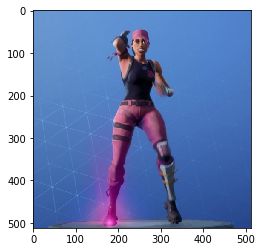

In [12]:

%matplotlib inline  

print(img_dir)

print(len(os.listdir(img_dir)))

img_path = sorted(img_dir.iterdir())[5]
img = cv2.imread(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

In [ ]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label,cord = get_pose(param, heatmap, paf)

print("Cord", cord, len(cord))
plt.imshow(label)

## make label images for pix2pix

In [16]:
print(save_dir)
# Source images
test_img_dir = save_dir.joinpath('test_img')
try:
    test_img_dir.mkdir(exist_ok=True)
except FileExistsError:
    print("Directory exists")
    

# Label images
test_label_dir = save_dir.joinpath('test_label_ori')
try:
    test_label_dir.mkdir(exist_ok=True)
except FileExistsError:
    print("Directory exists")

# Head images
test_head_dir  = save_dir.joinpath('test_head_ori')
try:
    test_head_dir.mkdir(exist_ok = True)
except FileExistsError:
    print("Directory exists")

NUM_FRAMES = len(os.listdir(str(img_dir)))
print("Number of frames", NUM_FRAMES)


pose_cords = []

for idx in tqdm(range(NUM_FRAMES)):
    img_path = img_dir.joinpath('{:05d}.png'.format(idx))
    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad(): 
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label, cord  = get_pose(param, heatmap, paf)
    index = 13
    crop_size =  25
    try: 
        head_cord = cord[index]
    except:
        head_cord = pose_cords[-1] # if there is no head point in this picture.
        #Use las frame head point
        
    pose_cords.extend([head_cord])
    head = img[ int(head_cord[1] - crop_size)  :int(head_cord[1] + crop_size),
                int(head_cord[0] - crop_size ) :int(head_cord[0] + crop_size),:
              ]
    
    #Show head
    plt.imshow(head)
    plt.savefig(str( test_head_dir.joinpath('pose_{}.jpg'.format(idx))))
    plt.clf()
    
    
    cv2.imwrite(str(test_img_dir.joinpath( '{:05}.png'.format(idx))), img)
    cv2.imwrite(str(test_label_dir.joinpath( '{:05}.png'.format(idx))), label)
    
    if idx % 100 == 0 and idx != 0:
        pose_cords_arr = np.array(pose_cords, dtype = np.int)
        # Save pose coordinates array.
        np.save(str(save_dir.joinpath('pose_source.npy')), pose_cords_arr)

pose_cords_arr = np.array( pose_cords, dtype = np.int )
np.save( str(save_dir.joinpath('pose_source.npy')), pose_cords_arr )
        
    
torch.cuda.empty_cache()

..\data\source
Number of frames 301



  0%|                                                                                          | 0/301 [00:00<?, ?it/s]

RuntimeError: CUDA error: the launch timed out and was terminated

In [ ]:
len(os.listdir(str(img_dir)))